# CP 5 Aprendizaje de Máquinas

---


## Support Vector Machine y Cross Validation


## Ejercicio 1: Preprocesamiento del Dataset

Vamos a trabajar con un dataset que contiene información acerca de pacientes (*gender, marital status, smoking status, age, etc*) con el ojetivo de predecir si es probable que tenga un ataque al corazón (*stroke*).
Además se incorpora de manera artificial la característica *doctor* que representa el doctor que recolectó los datos, la cual más adelante será usada para agrupar los datos.

In [1]:
import pandas as pd
import numpy as np

def get_prep_data():
    df = pd.read_csv(
        "./resources/healthcare-dataset-stroke-data.csv"
    )
    df["ever_married"] = (
        df["ever_married"].replace("Yes", True).replace("No", False)
    )
    df["gender"] = df["gender"].astype("category")
    df["smoking_status"] = df["smoking_status"].astype("category")
    df["Residence_type"] = df["Residence_type"].astype("category")
    df["work_type"] = df["work_type"].astype("category")
    df["doctor"] = np.random.randint(0, 8, size=len(df))
    
    return df


df = get_prep_data()

A continuación exploremos la estructura del dataset en cuestión:

In [2]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,9046,Male,67.0,0,1,True,Private,Urban,228.69,36.6,formerly smoked,1,2
1,51676,Female,61.0,0,0,True,Self-employed,Rural,202.21,NaN,never smoked,1,7
2,31112,Male,80.0,0,1,True,Private,Rural,105.92,32.5,never smoked,1,7
3,60182,Female,49.0,0,0,True,Private,Urban,171.23,34.4,smokes,1,1
4,1665,Female,79.0,1,0,True,Self-employed,Rural,174.12,24.0,never smoked,1,1


Se observan variables categóricas las cuales es necesario codificar 

In [3]:
from sklearn.preprocessing import LabelEncoder
from typing import List

In [4]:
def encode_features(df: pd.DataFrame, features: List[str]):
    le = LabelEncoder()
    for feat in features:
        df[feat] = le.fit_transform(df[feat])

In [5]:
encode_features(df, ['gender', 'work_type', 'Residence_type', 'smoking_status'])

Observemos el dataset resultante:

In [6]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,9046,1,67.0,0,1,True,2,1,228.69,36.6,1,1,2
1,51676,0,61.0,0,0,True,3,0,202.21,NaN,2,1,7
2,31112,1,80.0,0,1,True,2,0,105.92,32.5,2,1,7
3,60182,0,49.0,0,0,True,2,1,171.23,34.4,3,1,1
4,1665,0,79.0,1,0,True,3,0,174.12,24.0,2,1,1


Comprobemos si para todas las muestras observadas en el dataset se tienen valores válidos. Para ello no deben existir valores `NaN`

In [7]:
df.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
doctor               False
dtype: bool

En caso de existir valores `NaN` estos deben ser eliminados o reemplazados por algún otro valor que sea válido y represente la ausencia de información para esa muestra.

In [8]:
df['bmi'].fillna(-1, inplace=True)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,9046,1,67.0,0,1,True,2,1,228.69,36.6,1,1,1
1,51676,0,61.0,0,0,True,3,0,202.21,-1.0,2,1,7
2,31112,1,80.0,0,1,True,2,0,105.92,32.5,2,1,2
3,60182,0,49.0,0,0,True,2,1,171.23,34.4,3,1,5
4,1665,0,79.0,1,0,True,3,0,174.12,24.0,2,1,1


Comprobemos la cantidad de muestras correspondientes a cada clase (1 para stroke, 0 para no stroke)

In [8]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Como se puede apreciar estamos en presencia de un dataset altamente desbalanceado

La función `get_X_y` separa el dataset según las columnas elegidas como características y la columna *stroke* que representa el objetivo a predecir. Además se separa la columna *doctor* por la cual se quiere agrupar.

In [9]:
def get_X_y(train):
    FEATURES = [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "ever_married",
        "work_type",
        "Residence_type",
        "avg_glucose_level",
        "bmi",
        "smoking_status",
    ]

    GROUPS = "doctor"

    TARGET = "stroke"

    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    return X, y, groups

## Ejercicio 2: Clasificación usando Support Vector Machine

Se divide el dataset en conjunto de entrenamiento y conjunto de prueba.

In [10]:
from sklearn.model_selection import train_test_split

X, y, groups = get_X_y(df)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1)

Proponemos usar la clase `SVC` como implementación para Support Vector Machine, la cual podemos encontrar en `sklearn`, para entrenar un clasificador en el conjunto de entrenamiento obtenido. Por defecto `SVC` usa `rbf` como función de kernel.

In [11]:
from sklearn.svm import SVC

In [12]:
clf = SVC()
clf.fit(X_tr, y_tr)

SVC()

### Métricas



In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score

### Baseline

In [14]:
baseline = np.random.randint(0,2,y_val.shape)

acc_score = accuracy_score(y_val, baseline)
auc_score = roc_auc_score(y_val, baseline)
print(
    f"Our baseline on the holdout set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
)

Our baseline on the holdout set is 0.5205 and AUC is 0.5034


In [15]:
pred = clf.predict(X_val)

acc_score_1 = accuracy_score(y_val, pred)
auc_score_1 = roc_auc_score(y_val, pred)
print(
    f"Accuracy on the validation set is {acc_score_1:0.4f} and AUC is {auc_score_1:0.4f}"
)

Accuracy on the validation set is 0.9393 and AUC is 0.5000


### Cross Validation

We will learn:
1. Example where not using cross validation causes us to believe our model is better than it is.
2. Show the different cross validation techniuqes and when to apply them.
3. Run our example from part 1 using the correct cross validation technique.

In [16]:
import matplotlib.pylab as plt
from matplotlib.patches import Patch

plt.style.use('seaborn-white')

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_


Bad key text.latex.preview in file /home/dayany/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/dayany/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/dayany/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [17]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)

# KFold
- Split dataset into k consecutive folds (without shuffling by default).

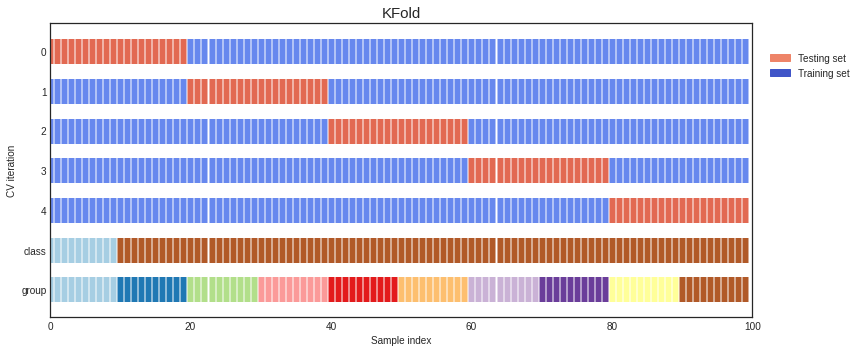

In [18]:
kf = KFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

# Stratified KFold
- KFold but the folds are made by preserving the percentage of samples for each class.

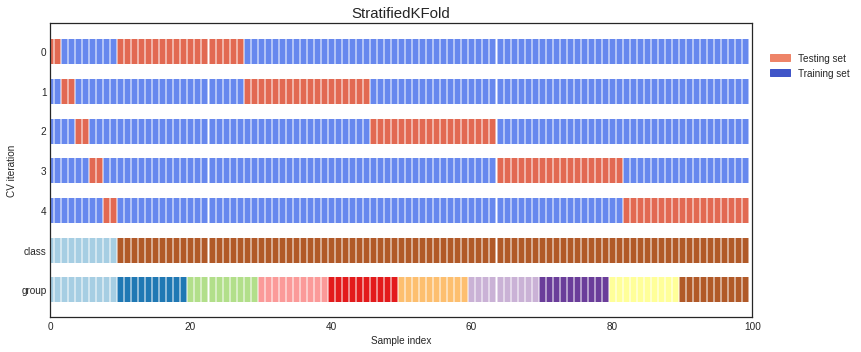

In [19]:
skf = StratifiedKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

# Group KFold

The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

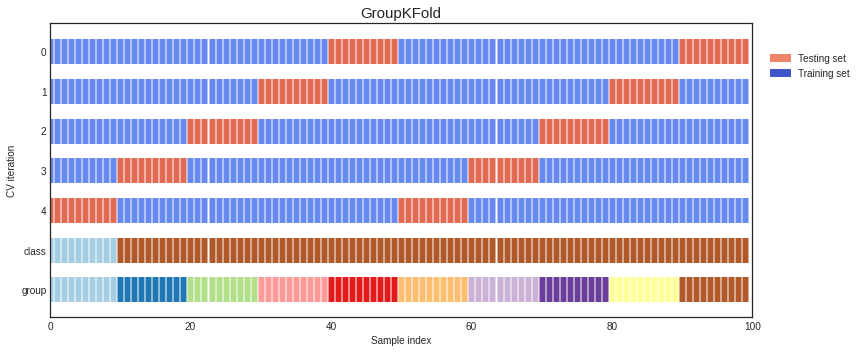

In [20]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

In [21]:
plot_cv(GroupKFold, )

TypeError: plot_cv() missing 3 required positional arguments: 'X', 'y', and 'groups'

# Stratified Group KFold

The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to create folds which preserve the percentage of samples for each class as much as possible given the constraint of non-overlapping groups between splits.

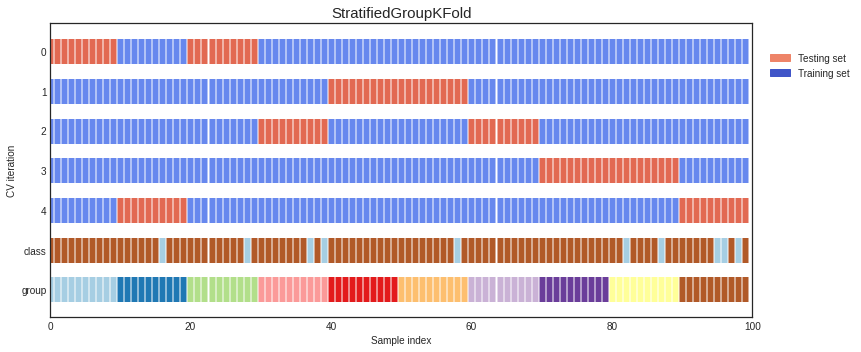

In [22]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

# Time Series Split

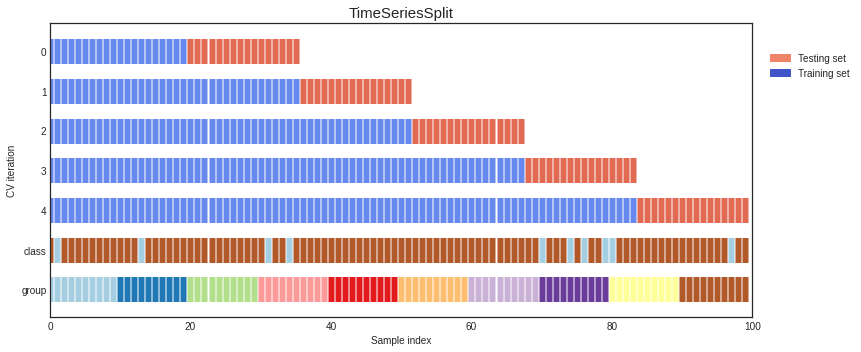

In [23]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)

## Ejercicio 3: Cross Validation aplicado a SVM 
1. Small/imblanced -> Stratified
2. Group
3. Shuffle in on

`StratifiedGroupKFold` is a good choice for this situation.

In [40]:
def train_with_cv(clf):
    sgk = StratifiedKFold(n_splits=5, shuffle=True, random_state=529)

    X, y, groups = get_X_y(df)

    fold = 0
    aucs = []
    for train_idx, val_idx in sgk.split(X, y, groups):
        X_tr = X.loc[train_idx]
        y_tr = y.loc[train_idx]

        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]

        # Fit Model on Train
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        auc_score = roc_auc_score(y_val, pred)
        print(f"======= Fold {fold} ========")
        print(
            f"Our AUC on the validation set is {auc_score:0.4f}"
        )
        fold += 1
        aucs.append(auc_score)
    oof_auc = np.mean(aucs)
    print(f'Our out of fold AUC score is {oof_auc:0.4f}')

In [41]:
train_with_cv(SVC())

======= Fold 0 ========
Our AUC on the validation set is 0.5000
======= Fold 1 ========
Our AUC on the validation set is 0.5000
======= Fold 2 ========
Our AUC on the validation set is 0.5000
======= Fold 3 ========
Our AUC on the validation set is 0.5000
======= Fold 4 ========
Our AUC on the validation set is 0.5000
Our out of fold AUC score is 0.5000


Our averaged out of fold score is a much better estimation of how our model will perform on unseen data.

## Ejercicio 4: Cross Validation para el resto de los clasificadores

In [ ]:
from sklearn.naive_bayes import GaussianNB

train_with_cv(GaussianNB())

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

train_with_cv(KNeighborsClassifier())

In [ ]:
from sklearn.tree import DecisionTreeClassifier

train_with_cv(DecisionTreeClassifier(criterion="entropy"))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_with_cv(RandomForestClassifier(criterion="entropy"))

In [ ]:
from sklearn.linear_model import LogisticRegression

train_with_cv(LogisticRegression(solver='liblinear'))